In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.sandbox.stats.multicomp import multipletests

In [2]:
def mean_ci(series):
    se = np.std(series, ddof=1) / np.sqrt(series.count())
    
    return (
        round(np.mean(series) - 1.96 * se, 4),
        round(np.mean(series) + 1.96 * se, 4)
    )

In [3]:
def mean_diff_ci(test, control):
    test_size = len(test)
    cntrl_size = len(control)
    
    test_var = np.var(test, ddof=1)
    cntrl_var = np.var(control, ddof=1)
    
    sp = np.sqrt((test_var * (test_size - 1) + cntrl_var * (test_var - 1)) / (test_size + cntrl_size - 2))
    se = sp * np.sqrt(1 / test_size + 1 / cntrl_size)
    
    return (
        round(test.mean() - control.mean() - 1.96 * se, 4),
        round(test.mean() - control.mean() + 1.96 * se, 4)
    )

In [4]:
def mean_test(test_group, control_group):
    t_res = ttest_ind(test_group, control_group, usevar="pooled")
    mw_res = mannwhitneyu(test_group, control_group, alternative='two-sided')

    print("Two Sample t-test")
    print("t =", t_res[0])
    print("p-value =", t_res[1])
    print("df = ", t_res[2])
    
    print("test mean =", test_group.mean())
    print("test ci =", mean_ci(test_group))
    
    print("control mean =", control_group.mean())
    print("control ci =", mean_ci(control_group))
    
    print("ci for diff =", mean_diff_ci(test_group, control_group))
    print()
    
    print("Mann-Whitney rank test")
    print("u =", mw_res[0])
    print("p-value =", mw_res[1])
    
    return [
        test_group.mean(), mean_ci(test_group), 
        control_group.mean(), mean_ci(control_group), 
        mean_diff_ci(test_group, control_group), t_res[1],
    ]

In [5]:
df = pd.read_csv('hw4.csv', sep=';', decimal=',', index_col=0)

In [6]:
df.head()

,purchaseSystem,orderRevenue,experimentVariant
1,Pp,15.99,Treatment
2,Pp,17.99,Treatment
3,Pp,15.99,Treatment
4,Pp,15.99,Treatment
5,Pp,17.99,Treatment


In [7]:
df.groupby(['experimentVariant']).agg(['count', 'mean'])

orderRevenue           
                         count       mean
experimentVariant                        
Control                    846  17.059740
Treatment                  793  16.972346

In [8]:
df.groupby(['experimentVariant', 'purchaseSystem']).agg(['count', 'mean'])

orderRevenue           
                                        count       mean
experimentVariant purchaseSystem                        
Control           Pp                      595  15.988319
                  St                      121  20.932149
                  Yc                      130  18.359231
Treatment         Pp                      546  16.094396
                  St                      143  21.843147
                  Yc                      104  14.884231

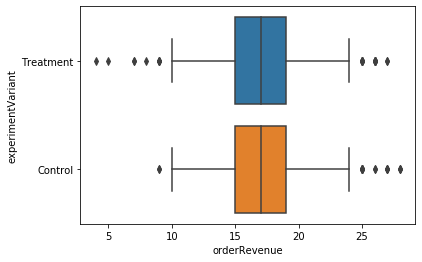

In [9]:
ax = sns.boxplot(x="orderRevenue", y="experimentVariant", data=df)

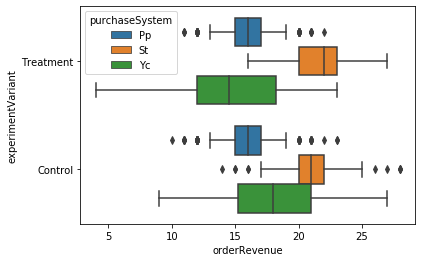

In [10]:
ax = sns.boxplot(x="orderRevenue", y="experimentVariant", hue="purchaseSystem", data=df)

In [11]:
_ = mean_test(
    df[df['experimentVariant'] == 'Treatment']['orderRevenue'],
    df[df['experimentVariant'] == 'Control']['orderRevenue']
)

Two Sample t-test
t = -0.5454665321607903
p-value = 0.5855070058877427
df =  1637.0
test mean = 16.972345523328947
test ci = (16.7357, 17.209)
control mean = 17.05973995271849
control ci = (16.8518, 17.2676)
ci for diff = (-0.3178, 0.143)

Mann-Whitney rank test
u = 331950.5
p-value = 0.7141016723544875


In [12]:
result = pd.DataFrame(columns=[
    'test', 'control', 'test_mean', 'test_ci', 'control_mean', 'control_ci', 'mean_diff_ci', 'p_value'
])

In [13]:
%%capture
t = df[(df['experimentVariant'] == 'Treatment') & (df['purchaseSystem'] == 'Pp')]['orderRevenue']
c = df[(df['experimentVariant'] == 'Control') & (df['purchaseSystem'] == 'Pp')]['orderRevenue']
result.loc[0] = ['Pp', 'Pp'] + list(mean_test(t, c))

In [14]:
%%capture
t = df[(df['experimentVariant'] == 'Treatment') & (df['purchaseSystem'] == 'St')]['orderRevenue']
c = df[(df['experimentVariant'] == 'Control') & (df['purchaseSystem'] == 'St')]['orderRevenue']
result.loc[1] = ['St', 'St'] + mean_test(t, c)

In [15]:
%%capture
t = df[(df['experimentVariant'] == 'Treatment') & (df['purchaseSystem'] == 'Yc')]['orderRevenue']
c = df[(df['experimentVariant'] == 'Control') & (df['purchaseSystem'] == 'Yc')]['orderRevenue']
result.loc[2] = ['Yc', 'Yc'] + mean_test(t, c)

In [16]:
result = result.sort_values(by="p_value")

In [17]:
# коррекция Бонферонни: оптимизация FWER
_, bonferroni_p, _, _ = multipletests(result.p_value, method='bonferroni')
result["bonferroni_p"] = bonferroni_p

In [18]:
# коррекция Холма: более мощная поправка, чем Бонферонни
_, holm_p, _, _ = multipletests(result.p_value, method='holm')
result["holm_p"] = holm_p

In [19]:
# коррекция Бенджамини-Хохберга: коррекция FDR, самая мощная из представленных поправок
_, bh_p, _, _ = multipletests(result.p_value, method='fdr_bh')
result["bh_p"] = bh_p

In [20]:
result

,test,control,test_mean,test_ci,control_mean,control_ci,mean_diff_ci,p_value,bonferroni_p,holm_p,bh_p
2,Yc,Yc,14.884231,"(14.051, 15.7174)",18.359231,"(17.6905, 19.028)","(-4.27, -2.68)",6.356119e-10,1.906836e-09,1.906836e-09,1.906836e-09
1,St,St,21.843147,"(21.4615, 22.2248)",20.932149,"(20.4853, 21.379)","(0.4886, 1.3334)",2.463201e-03,7.389603e-03,4.926402e-03,3.694801e-03
0,Pp,Pp,16.094396,"(15.9264, 16.2624)",15.988319,"(15.8196, 16.157)","(-0.0553, 0.2674)",3.836418e-01,1.000000e+00,3.836418e-01,3.836418e-01
